In [1]:
import glacierml

# Step 0. Match the indices in RGI with those in GlaThiDa
This corresponds to the file ```workflow_step0_merge_training_data.py```. But note that this is can't really be run in a notebook because with ```useMP=True``` then note that multiprocessing doesn't play well with notebooks...

In [2]:
pth = '/data/fast1/glacierml/data/'
# output=glacierml.match_GlaThiDa_RGI_index(pth=pth, useMP=True);
# This writes the file to:  pth + '/v2/GlaThiDa_with_RGIId_v2.csv'

# Step 1. Build and train models.
This corresponds to the file ```workflow_step1_run_bootstrap_and_ensemble.py```.
Here, to illustrate the general ideas, we just build and train a single model rather than
going through the bootstrap/ensemble process.

First, load the training data,

In [3]:
parameterization, dataset, dataset.name, res = \
    glacierml.select_dataset_coregistration(pth=pth)
dataset

,CenLat,CenLon,Slope,Zmin,Zmed,Zmax,Area,Aspect,Lmax,Thickness
0,63.469173,-146.528168,12.0,722,1841,3081,234.583,30,41911,235.0
1,63.281000,-145.427000,14.0,1162,1858,2438,17.567,172,8639,147.0
2,58.380000,-134.349000,10.0,676,1123,1494,9.528,327,6332,66.0
3,69.276000,-143.819000,22.0,2360,2440,2554,0.153,219,680,83.0
4,69.276000,-143.819000,22.0,2360,2440,2554,0.153,219,680,82.0
...,...,...,...,...,...,...,...,...,...,...
495,-65.052700,-63.393600,0.0,10,-999,50,0.213,-9,318,312.0
496,-62.047200,-58.376500,7.4,30,-999,630,7.240,150,5187,238.0
497,-62.675200,-60.390600,10.0,10,-999,370,1.160,260,1118,89.0
498,-62.670700,-60.354700,6.7,10,-999,370,5.493,273,3056,97.0


In [4]:
import numpy as np
dataset['Area'] = dataset['Area'] * 1e6
dataset['Area'] = np.log(dataset['Area'])
dataset['Lmax'] = np.log(dataset['Lmax'])

/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [21]:
dataset['Lmax'].max()

11.321547018086019

In [5]:
dataset

,CenLat,CenLon,Slope,Zmin,Zmed,Zmax,Area,Aspect,Lmax,Thickness
0,63.469173,-146.528168,12.0,722,1841,3081,19.273320,30,10.643304,235.0
1,63.281000,-145.427000,14.0,1162,1858,2438,16.681533,172,9.064042,147.0
2,58.380000,-134.349000,10.0,676,1123,1494,16.069745,327,8.753371,66.0
3,69.276000,-143.819000,22.0,2360,2440,2554,11.938193,219,6.522093,83.0
4,69.276000,-143.819000,22.0,2360,2440,2554,11.938193,219,6.522093,82.0
...,...,...,...,...,...,...,...,...,...,...
495,-65.052700,-63.393600,0.0,10,-999,50,12.269047,-9,5.762051,312.0
496,-62.047200,-58.376500,7.4,30,-999,630,15.795132,150,8.553911,238.0
497,-62.675200,-60.390600,10.0,10,-999,370,13.963931,260,7.019297,89.0
498,-62.670700,-60.354700,6.7,10,-999,370,15.518985,273,8.024862,97.0


Then train a single NN model with the data:

In [6]:
# lr_input = 0.01
rs = 0
# ep_input = 2000
layer_1_input = 10
layer_2_input = 5
dropout = True

dnn_model = glacierml.build_and_train_model(
                        dataset, 
#                         learning_rate = float(lr_input), 
#                         random_state = rs, 
#                         epochs = int(ep_input), 
                        parameterization = parameterization, 
                        res = res,
                        layer_1 = layer_1_input,
                        layer_2 = layer_2_input,
                        dropout = dropout,
                        writeToFile = False
)   

2023-01-17 10:45:29.251249: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-01-17 10:45:29.251276: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-01-17 10:45:29.251612: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
dnn_model

In [8]:
model_thicknesses = glacierml.evaluate_model('10-5', rs, dataset, dnn_model)
model_thicknesses

   Line1
0      1


,model,test mae,train mae,architecture,coregistration,total parameters
0,0.0,NaN,NaN,10-5,df,180.0


In [9]:
model_statistics = glacierml.calculate_model_avg_statistics(
            dnn_model,
            '10-5',
            dataset,
            model_thicknesses
        )
model_statistics

,layer architecture,total parameters,trained parameters,total inputs,test mae avg,train mae avg,test mae std dev,train mae std dev


In [10]:
RGI = glacierml.load_RGI()
# RGI = RGI.drop(['RGIId', 'region'], axis = 1)
RGI

,RGIId,CenLat,CenLon,Slope,Zmin,Zmed,Zmax,Area,Aspect,Lmax,region
0,RGI60-01.00001,63.6890,-146.8230,42.0,1936,2385,2725,0.360,346,839,01
1,RGI60-01.00002,63.4040,-146.6680,16.0,1713,2005,2144,0.558,162,1197,01
2,RGI60-01.00003,63.3760,-146.0800,18.0,1609,1868,2182,1.685,175,2106,01
3,RGI60-01.00004,63.3810,-146.1200,19.0,1273,1944,2317,3.681,195,4175,01
4,RGI60-01.00005,63.5510,-147.0570,16.0,1494,1914,2317,2.573,181,2981,01
...,...,...,...,...,...,...,...,...,...,...,...
216496,RGI60-19.02748,-53.9860,-37.7325,29.9,310,-999,510,0.042,315,255,19
216497,RGI60-19.02749,-54.8310,-36.1361,23.6,330,-999,830,0.567,200,1130,19
216498,RGI60-19.02750,-54.1884,-37.3018,16.8,10,-999,1110,4.118,308,4329,19
216499,RGI60-19.02751,-68.8656,-90.4266,0.4,170,-999,270,0.011,122,106,19


In [11]:
# RGI['region'] = RGI['RGIId'].str[6:8]
for region_selection in range(1,20,1):
#     print(region_selection)
    
    
    
    if len(str(region_selection)) == 1:
        N = 1
        region_selection = str(region_selection).zfill(N + len(str(region_selection)))
    else:
        region_selection = region_selection

    
    RGI = RGI.reset_index()
    RGI = RGI.drop('index', axis=1)
#     if region_selection != '19':
    drops = RGI[
        ((RGI['region'] == str(region_selection)) & (RGI['Zmin'] < 0)) |
        ((RGI['region'] == str(region_selection)) & (RGI['Zmed'] < 0)) |
        ((RGI['region'] == str(region_selection)) & (RGI['Zmax'] < 0)) |
        ((RGI['region'] == str(region_selection)) & (RGI['Slope'] < 0)) |
        ((RGI['region'] == str(region_selection)) & (RGI['Aspect'] < 0))
    ].index
#         print(drops)
#         if not drops.empty:
#             print('dropping bad data')
    RGI = RGI.drop(drops)
RGI

,RGIId,CenLat,CenLon,Slope,Zmin,Zmed,Zmax,Area,Aspect,Lmax,region
0,RGI60-01.00001,63.6890,-146.823,42.0,1936,2385,2725,0.360,346,839,01
1,RGI60-01.00002,63.4040,-146.668,16.0,1713,2005,2144,0.558,162,1197,01
2,RGI60-01.00003,63.3760,-146.080,18.0,1609,1868,2182,1.685,175,2106,01
3,RGI60-01.00004,63.3810,-146.120,19.0,1273,1944,2317,3.681,195,4175,01
4,RGI60-01.00005,63.5510,-147.057,16.0,1494,1914,2317,2.573,181,2981,01
...,...,...,...,...,...,...,...,...,...,...,...
213702,RGI60-18.03533,-43.4215,170.354,34.7,1231,1724,2098,0.189,116,944,18
213703,RGI60-18.03534,-43.4550,170.349,36.1,1881,2106,2208,0.040,108,331,18
213704,RGI60-18.03535,-43.4400,170.351,39.2,1677,1974,2253,0.184,104,740,18
213705,RGI60-18.03536,-43.4106,170.364,34.0,1627,1839,1928,0.111,135,406,18


In [12]:
RGI = RGI.drop(['RGIId', 'region'], axis = 1)

In [13]:
RGI['Area'] = RGI['Area'] * 1e6
RGI['Area'] = np.log(RGI['Area'])
RGI['Lmax'] = np.log(RGI['Lmax'])

/home/sa42/miniconda3/envs/python-cartopy-f/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
RGI

,CenLat,CenLon,Slope,Zmin,Zmed,Zmax,Area,Aspect,Lmax
0,63.6890,-146.823,42.0,1936,2385,2725,12.793859,346,6.732211
1,63.4040,-146.668,16.0,1713,2005,2144,13.232114,162,7.087574
2,63.3760,-146.080,18.0,1609,1868,2182,14.337276,175,7.652546
3,63.3810,-146.120,19.0,1273,1944,2317,15.118695,195,8.336870
4,63.5510,-147.057,16.0,1494,1914,2317,14.760583,181,8.000014
...,...,...,...,...,...,...,...,...,...
213702,-43.4215,170.354,34.7,1231,1724,2098,12.149502,116,6.850126
213703,-43.4550,170.349,36.1,1881,2106,2208,10.596635,108,5.802118
213704,-43.4400,170.351,39.2,1677,1974,2253,12.122691,104,6.606650
213705,-43.4106,170.364,34.0,1627,1839,1928,11.617285,135,6.006353


In [15]:
predictions = dnn_model.predict(RGI, verbose = 0)
predictions

array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]], dtype=float32)

In [16]:
import pandas as pd
predictions = pd.DataFrame(predictions)
df = pd.merge(RGI, predictions, left_index = True, right_index = True)
df = df.rename(columns = {0:'Mean Thickness'})

In [17]:
df

,CenLat,CenLon,Slope,Zmin,Zmed,Zmax,Area,Aspect,Lmax,Mean Thickness
0,63.6890,-146.823,42.0,1936,2385,2725,12.793859,346,6.732211,NaN
1,63.4040,-146.668,16.0,1713,2005,2144,13.232114,162,7.087574,NaN
2,63.3760,-146.080,18.0,1609,1868,2182,14.337276,175,7.652546,NaN
3,63.3810,-146.120,19.0,1273,1944,2317,15.118695,195,8.336870,NaN
4,63.5510,-147.057,16.0,1494,1914,2317,14.760583,181,8.000014,NaN
...,...,...,...,...,...,...,...,...,...,...
213702,-43.4215,170.354,34.7,1231,1724,2098,12.149502,116,6.850126,NaN
213703,-43.4550,170.349,36.1,1881,2106,2208,10.596635,108,5.802118,NaN
213704,-43.4400,170.351,39.2,1677,1974,2253,12.122691,104,6.606650,NaN
213705,-43.4106,170.364,34.0,1627,1839,1928,11.617285,135,6.006353,NaN


In [18]:
np.exp(df['Area'])/1e6

0         0.360
1         0.558
2         1.685
3         3.681
4         2.573
          ...  
213702    0.189
213703    0.040
213704    0.184
213705    0.111
213706    0.085
Name: Area, Length: 213707, dtype: float64

Text(0, 0.5, 'Mean Thickness')

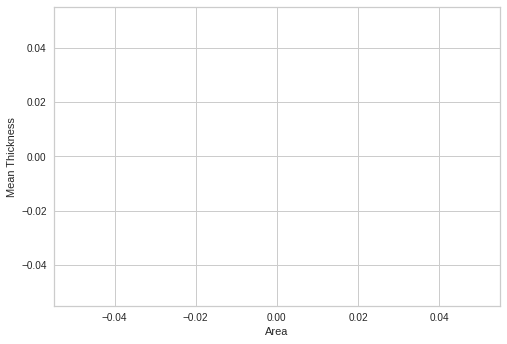

In [19]:
import matplotlib.pyplot as plt
plt.scatter(df['Lmax'],df['Mean Thickness'])
plt.xlabel('Area')
plt.ylabel('Mean Thickness')